## Data 설명
* store_id : 각 파일에서의 상점 고유 번호 (해당기한 내 개업 혹은 폐업한 상점도 있음)
* date : 거래일자
* time : 거래시간
* card_id : 카드 번호의 hash 값
* amount : 매출 금액, 음수인 경우 취소 거래
* installments : 할부 개월 수. 일시불은 0
* days_of_week : 요일, 월요일이 0, 일요일은 6
* holiday : 1이면 공휴일, 0이면 공휴일 아님

In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import qgrid

In [2]:
path = './data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission  = pd.read_csv(path + 'submission.csv')

## Check Simple EDA

In [14]:
train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0


### 결측치 파악
* installments에서 결측치는 0이라 언급된바 있으므로 0으로 대체

In [36]:
def info_df(data):
    '''data의 type, null_count, null_rate를 알려주는 함수
    
    Parameter
    ---------
    data(DataFrame) : 파악하고자하는 Data
       
    '''
    info_df = pd.DataFrame({"type":data.dtypes,
                            'null_count':data.isnull().sum(),
                           'null_rate':data.isnull().sum()/data.isnull().count() * 100})  
    info_df['uni_count'] = data.apply(lambda x : x.nunique())
    
    return info_df

In [38]:
info_df(train)

,type,null_count,null_rate,uni_count
store_id,int64,0,0.0,1775
date,object,0,0.0,730
time,object,0,0.0,85924
card_id,object,0,0.0,922522
amount,int64,0,0.0,6031
installments,float64,0,0.0,17
days_of_week,int64,0,0.0,7
holyday,int64,0,0.0,2


In [39]:
info_df(test)

,type,null_count,null_rate,uni_count
store_id,int64,0,0.0,200
date,object,0,0.0,608
time,object,0,0.0,72181
card_id,object,0,0.0,214584
amount,int64,0,0.0,2809
installments,float64,0,0.0,12
days_of_week,int64,0,0.0,7
holyday,int64,0,0.0,2


In [7]:
train.installments.fillna(0,inplace = True)
test.installments.fillna(0, inplace = True)

### 날짜
* 주기적으로 특정일자에 매출이 감소함

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


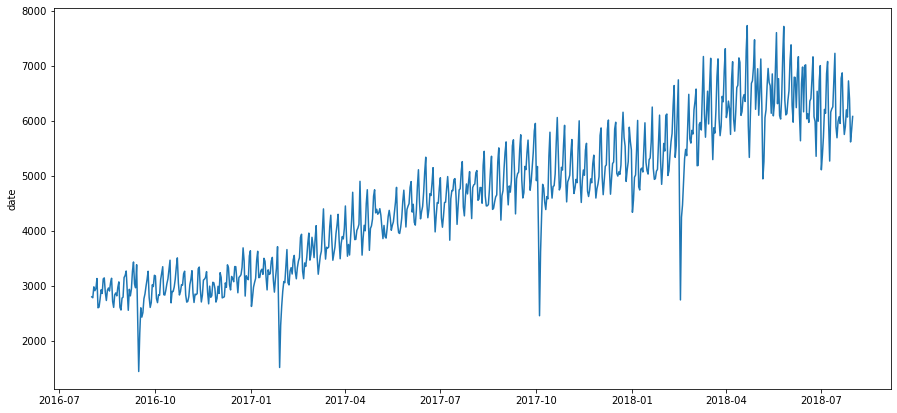

In [5]:
#object -> datetime으로 전환
dates = pd.to_datetime(train.date)
dates = dates.value_counts().sort_index()

plt.figure(figsize=(15,7))
sns.lineplot(x = dates.index, y = dates)
plt.show()

### 요일
* 0이 월요일이고, 6이 일요일
* 금토에 소비횟수가 가장많고, 일요일이 가장 소비횟수가 적음

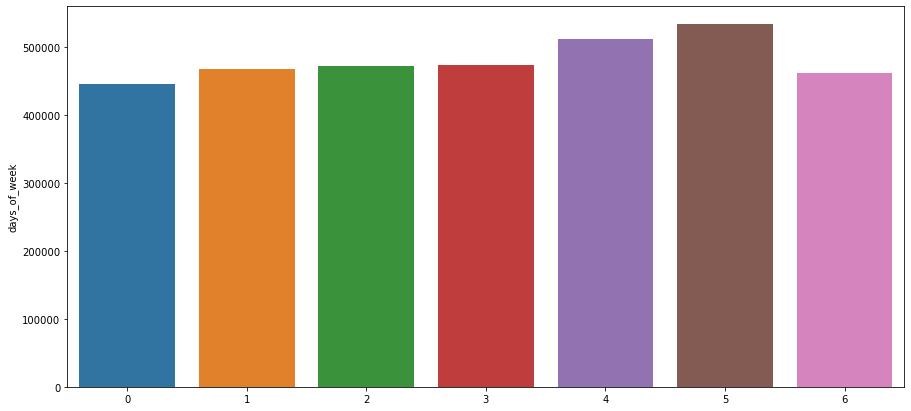

In [6]:
weeks = train.days_of_week.value_counts()

plt.figure(figsize=(15,7))
sns.barplot(x = weeks.index, y = weeks)
plt.show()

### time
* 오전 시간대 매출이 가장 적고, 그다음은 14-16시 이전이다

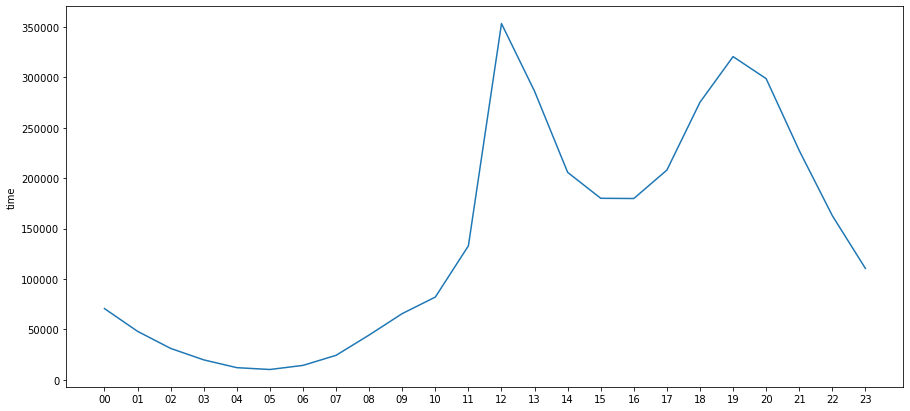

In [7]:
hours = train.time.apply(lambda x :x[:2])
hours = hours.value_counts().sort_index()

plt.figure(figsize = (15,7))
sns.lineplot(x = hours.index, y = hours)
plt.show()

### installment_term
* 일시불의 비율이 96%이상, 할부의 비중은 1년이하가 가장많다

In [8]:
train['installment_cut'] = 0
train.installments.fillna(0,inplace = True)
train.loc[(train.installments>0)&(train.installments<13),'installment_cut'] = 1
train.loc[(train.installments>12)&(train.installments<25),'installment_cut'] = 2
train.loc[(train.installments>24)&(train.installments<37),'installment_cut'] = 3
train.loc[(train.installments>36),'installment_cut'] = 4

In [9]:
train['installment_cut'].value_counts(normalize=True)

0    0.994986
1    0.004977
2    0.000035
3    0.000001
Name: installment_cut, dtype: float64